# Midterm Project: Predicting Antibiotic-Producing Bacteria Using Morphological Features

## Project Goal

Build a classification model to predict whether a bacterial strain will exhibit antimicrobial activity based solely on its morphological features, achieving the best possible **AUC score** on validation data.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import sklearn
print(sklearn.__version__)

1.7.2


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [15]:
df_all = pd.read_csv("data_allrounds_activitybinary.csv", sep=";")
df_all.head()

,round,sample,ID_plate,centroid_1,centroid_2,growth_rate,peaks,circularity,eccentricity,RGB_mean_1,...,Lab_std_1,Lab_std_2,Lab_std_3,Labt_mean_1,Labt_mean_2,Labt_mean_3,Labt_std_1,Labt_std_2,Labt_std_3,activity_total
0,1,10µl-nr1,1-1,835,1242,"0,1338005",23,"0,96578","0,18561","246,7854",...,"11,1602","6,90168","8,14749","91,3267","6,5164","7,15765","10,7217","4,70734","7,27739",1
1,1,10µl-nr1,1-2,1484,1109,"0,063329023",13,"1,0207","0,22453","203,4753",...,"5,09732","3,40151","4,86611","69,7232","14,1296","19,6061","4,13404","3,4022","3,81545",0
2,1,10µl-nr2,2-2,493,580,"0,04584244",15,"1,0581","0,28171","207,9126",...,"7,38965","5,17052","3,67209","71,3072","19,8785","15,035","7,10437","5,2638","3,69122",0
3,1,10µl-nr2,2-4,1052,1305,"0,656070866",9,"1,0217","0,44729","186,424",...,"3,66983","2,71661","3,49231","65,0318","13,5466","13,9261","2,10122","2,40051","3,14126",0
4,1,10µl-nr2,2-5,1146,808,"0,053184523",22,"0,98664","0,25451","234,9079",...,"10,3683","7,04636","6,18122","76,051","25,1306","20,0857","6,40666","4,69942","3,93355",0


### Data preparation

In [16]:
#Clean column names
df_all.columns = df_all.columns.str.lower().str.replace(' ', '_')
df_all.columns

Index(['round', 'sample', 'id_plate', 'centroid_1', 'centroid_2',
       'growth_rate', 'peaks', 'circularity', 'eccentricity', 'rgb_mean_1',
       'rgbt_mean_2', 'rgbt_mean_3', 'rgbt_std_1', 'rgbt_std_2', 'rgbt_std_3',
       'lab_mean_1', 'lab_mean_2', 'lab_mean_3', 'lab_std_1', 'lab_std_2',
       'lab_std_3', 'labt_mean_1', 'labt_mean_2', 'labt_mean_3', 'labt_std_1',
       'labt_std_2', 'labt_std_3', 'activity_total'],
      dtype='object')

In [17]:
df_all.dtypes

round              int64
sample            object
id_plate          object
centroid_1         int64
centroid_2         int64
growth_rate       object
peaks              int64
circularity       object
eccentricity      object
rgb_mean_1        object
rgbt_mean_2       object
rgbt_mean_3       object
rgbt_std_1        object
rgbt_std_2        object
rgbt_std_3        object
lab_mean_1        object
lab_mean_2        object
lab_mean_3        object
lab_std_1         object
lab_std_2         object
lab_std_3         object
labt_mean_1       object
labt_mean_2       object
labt_mean_3       object
labt_std_1        object
labt_std_2        object
labt_std_3        object
activity_total     int64
dtype: object

In [18]:
np.mean(df_all.isnull().sum())


np.float64(0.0)

### Exploratory data analysis

In [19]:
for col in df_all.columns:
    print(col)
    print(df_all[col].unique()[:5])
    print(df_all[col].nunique()) #number of unique values
    print('---')

round
[1 2]
2
---
sample
['10µl-nr1' '10µl-nr2' '10µl-nr3' '10µl-nr4' '10µl-nr5']
51
---
id_plate
['1-1' '1-2' '2-2' '2-4' '2-5']
383
---
centroid_1
[ 835 1484  493 1052 1146]
390
---
centroid_2
[1242 1109  580 1305  808]
398
---
growth_rate
['0,1338005' '0,063329023' '0,04584244' '0,656070866' '0,053184523']
362
---
peaks
[23 13 15  9 22]
25
---
circularity
['0,96578' '1,0207' '1,0581' '1,0217' '0,98664']
432
---
eccentricity
['0,18561' '0,22453' '0,28171' '0,44729' '0,25451']
451
---
rgb_mean_1
['246,7854' '203,4753' '207,9126' '186,424' '234,9079']
453
---
rgbt_mean_2
['225,925' '160,3111' '160,9032' '148,5897' '169,5041']
451
---
rgbt_mean_3
['217,3063' '135,6222' '148,3548' '133,641' '151,9421']
453
---
rgbt_std_1
['22,9483' '16,0928' '28,7998' '7,89643' '21,5408']
453
---
rgbt_std_2
['31,6416' '10,0833' '15,8332' '5,8387' '17,2004']
453
---
rgbt_std_3
['36,2281' '7,72625' '13,2729' '5,50831' '16,3168']
453
---
lab_mean_1
['89,0539' '69,1886' '69,2019' '64,0392' '75,2906']
453
---

<Axes: xlabel='activity_total', ylabel='Count'>

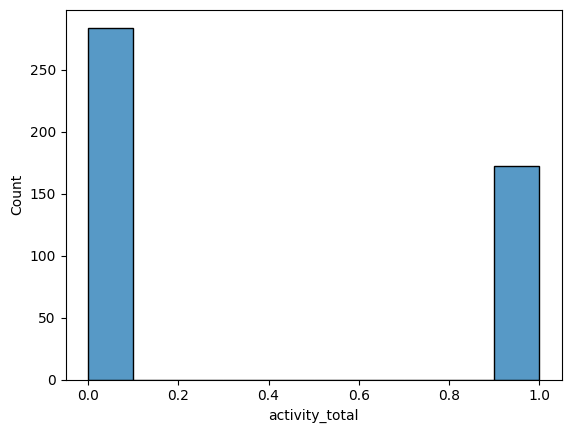

In [20]:
sns.histplot(df_all['activity_total'])

### Split data

In [21]:
df = df_all.iloc[:,5:28].copy()
df.head()

,growth_rate,peaks,circularity,eccentricity,rgb_mean_1,rgbt_mean_2,rgbt_mean_3,rgbt_std_1,rgbt_std_2,rgbt_std_3,...,lab_std_1,lab_std_2,lab_std_3,labt_mean_1,labt_mean_2,labt_mean_3,labt_std_1,labt_std_2,labt_std_3,activity_total
0,"0,1338005",23,"0,96578","0,18561","246,7854","225,925","217,3063","22,9483","31,6416","36,2281",...,"11,1602","6,90168","8,14749","91,3267","6,5164","7,15765","10,7217","4,70734","7,27739",1
1,"0,063329023",13,"1,0207","0,22453","203,4753","160,3111","135,6222","16,0928","10,0833","7,72625",...,"5,09732","3,40151","4,86611","69,7232","14,1296","19,6061","4,13404","3,4022","3,81545",0
2,"0,04584244",15,"1,0581","0,28171","207,9126","160,9032","148,3548","28,7998","15,8332","13,2729",...,"7,38965","5,17052","3,67209","71,3072","19,8785","15,035","7,10437","5,2638","3,69122",0
3,"0,656070866",9,"1,0217","0,44729","186,424","148,5897","133,641","7,89643","5,8387","5,50831",...,"3,66983","2,71661","3,49231","65,0318","13,5466","13,9261","2,10122","2,40051","3,14126",0
4,"0,053184523",22,"0,98664","0,25451","234,9079","169,5041","151,9421","21,5408","17,2004","16,3168",...,"10,3683","7,04636","6,18122","76,051","25,1306","20,0857","6,40666","4,69942","3,93355",0


In [22]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [23]:
print(df_train.shape, df_val.shape, df_test.shape)

(273, 23) (91, 23) (92, 23)


In [24]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# turn target value into binary
y_train = df_train.activity_total.astype('int').values
y_val = df_val.activity_total.astype('int').values
y_test = df_test.activity_total.astype('int').values

del df_train['activity_total']
del df_val['activity_total']
del df_test['activity_total']

### Decision tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [28]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [29]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [30]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.5397897897897898

In [162]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.594
   2 -> 0.594
   3 -> 0.594
   4 -> 0.593
   5 -> 0.505
   6 -> 0.557
  10 -> 0.505
  15 -> 0.474
  20 -> 0.534
None -> 0.563


In [193]:
scores = []

for depth in [1, 2, 3, 4]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

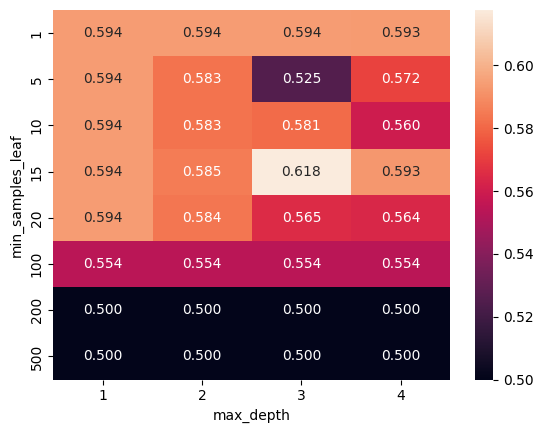

In [195]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
sns.heatmap(df_scores_pivot['auc'], annot=True, fmt=".3f")

After testing different parameters, **max_depth=3** and **min_samples_leaf=15** provide the best validation performance.

**Key findings:**
- Deeper trees (max_depth > 3) lead to overfitting on this dataset
- Requiring at least 15 samples per leaf prevents the model from learning noise
- This configuration balances model complexity with generalization

In [222]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)
dt.fit(X_train, y_train)
#print(export_text(dt, feature_names=list(dt.get_feature_names_out())))

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [223]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6176176176176176

### Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
scores = []

for d in [4,5,6]:
    for n in range(10, 501, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [244]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

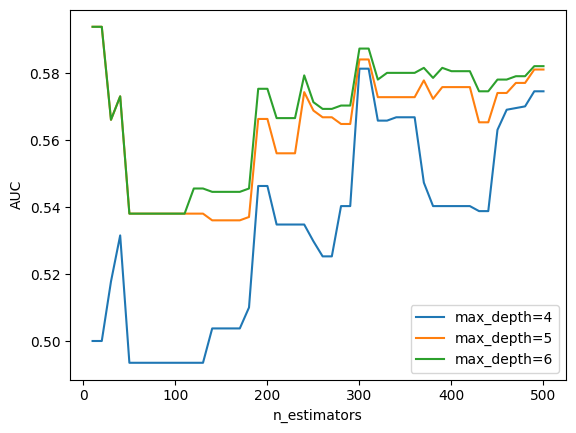

In [245]:
for d in [4,5,6]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend()

- **max_depth=6** (green): Plateaus quickly at ~0.585 AUC after ~100 trees
- **max_depth=5** (orange): Similar performance to depth=6, stable around 0.585 AUC
- **max_depth=4** (blue): Shows a spike at ~400 estimators reaching ~0.598 AUC, but this appears to be validation set noise rather than genuine improvement (drops immediately after)

**Decision:** Use **max_depth=5** with **200-300 estimators**. The spike in max_depth=4 is likely overfitting to the validation set and not worth the 2× increase in trees.


In [36]:
max_depth = 5

In [247]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [248]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

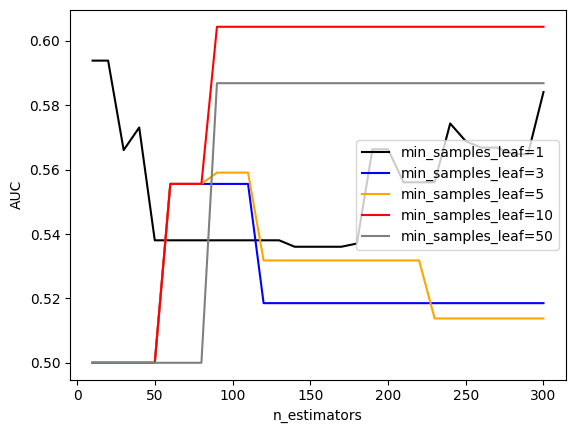

In [253]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    
plt.xlabel('n_estimators')
plt.ylabel('AUC')

plt.legend()

- **min_samples_leaf=1** (black): Higher AUC (~0.59) but more volatile - likely overfitting
- **min_samples_leaf=10** (red): Best stable performance, plateaus after ~100 estimators
- **min_samples_leaf=50** (grey): Too restrictive, underperforms (~0.57 AUC)

**Decision:** **min_samples_leaf=10** provides the best trade-off between performance and stability. The model converges quickly (by 100 trees) and maintains consistent validation performance.

In [35]:
min_samples_leaf = 10

In [268]:
scores = []

for m in ['sqrt', 'log2', None, 1, 0.2, 0.5, 0.7]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=m,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((m, n, auc))

In [269]:
columns = ['max_features', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

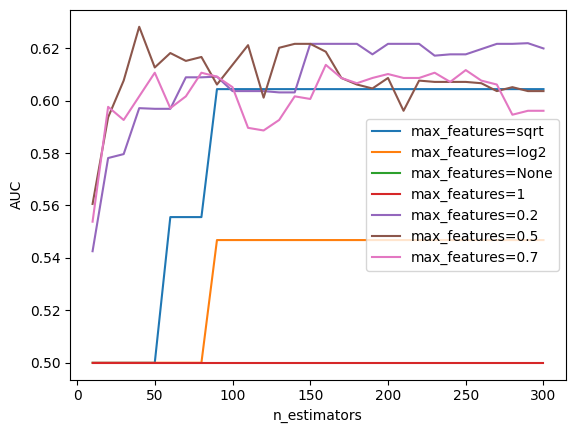

In [270]:
for m in ['sqrt', 'log2', None, 1, 0.2, 0.5, 0.7]:
    df_subset = df_scores[df_scores.max_features == m]

    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_features=%s' % m)
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend()

Testing different feature subsampling strategies:
- **max_features=0.2**: Best performance (~0.60 AUC) - uses only 20% of features per split
- **max_features='sqrt'**: Standard default for classification, slightly lower performance
- **max_features=None**: Uses all features, leads to correlated trees and lower performance

**Key insight:** The strong performance with max_features=0.2 suggests:
1. The dataset has many **correlated or redundant features**
2. High feature randomness increases **tree diversity** and ensemble strength
3. Using fewer features per split acts as **implicit regularization**

**Decision:** Use **max_features=0.2** to maximize validation AUC.

In [34]:
max_features = 0.2

In [37]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,0.2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6216216216216217

### XGBoost

In [324]:
import xgboost as xgb

In [325]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [326]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [327]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [328]:
scores = {}

for e in [0.2, 0.6, 1]:
    xgb_params = {
        'eta': e, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0,  # suppress output
    }
    
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=evals_result,
                      verbose_eval=False)
    
    key = f'eta={e}'
    df_result = pd.DataFrame({
        'num_iter': range(len(evals_result['train']['auc'])),
        'train_auc': evals_result['train']['auc'],
        'val_auc': evals_result['val']['auc']
    })
    scores[key] = df_result


In [329]:
scores.keys()

dict_keys(['eta=0.2', 'eta=0.6', 'eta=1'])

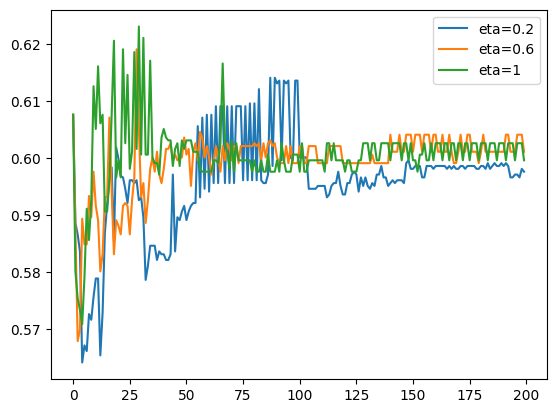

In [330]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

- **eta=0.2** (blue): Slow, steady learning but doesn't reach optimal performance in 200 rounds
- **eta=0.6** (purple): Good balance - reaches ~0.60 AUC and stabilizes
- **eta=1.0**: Fastest convergence but shows high volatility 

**Decision:** Use **eta=0.6** as it provides:
1. Fast convergence (reaches plateau by ~50 iterations)
2. Stable validation performance
3. Lower risk of overfitting compared to eta=1.0

**Note:** Higher eta means each tree contributes more to predictions, requiring fewer total trees but with higher risk of overfitting.


In [331]:
scores = {}

for d in [2, 4, 6, 8]:
    xgb_params = {
        'eta': 0.6, 
        'max_depth': d,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0,  # suppress output
    }
    
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=evals_result,
                      verbose_eval=False)

    key = f'max_depth={d}'
    df_result = pd.DataFrame({
        'num_iter': range(len(evals_result['train']['auc'])),
        'train_auc': evals_result['train']['auc'],
        'val_auc': evals_result['val']['auc']
    })
    scores[key] = df_result

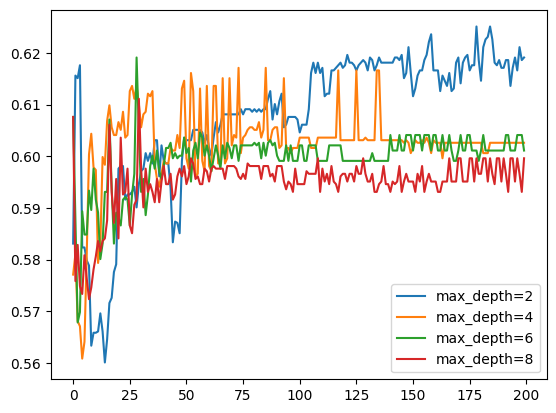

In [332]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

#plt.ylim(0.8, 0.84)
plt.legend()

- **max_depth=2**: Best validation performance (~0.60 AUC) - shallow trees prevent overfitting
- **max_depth=4, 6, 8**: Deeper trees show similar or worse performance, suggesting they're learning noise

**Key insight:** Unlike Random Forest (which benefited from max_depth=5), XGBoost works best with **very shallow trees (depth=2)**. This is common in gradient boosting because:
1. Each tree only needs to correct residual errors (not learn the full pattern)
2. Shallow trees act as strong regularization
3. The boosting process compensates for individual tree simplicity

**Decision:** Use **max_depth=2** for optimal generalization.

In [333]:
scores = {}

for c in [1, 3, 5, 7]:
    xgb_params = {
        'eta': 0.6, 
        'max_depth': 2,
        'min_child_weight': c,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0,  # suppress output
    }
    
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=evals_result,
                      verbose_eval=False)

    key = f'min_child_weight={c}'
    df_result = pd.DataFrame({
        'num_iter': range(len(evals_result['train']['auc'])),
        'train_auc': evals_result['train']['auc'],
        'val_auc': evals_result['val']['auc']
    })
    scores[key] = df_result

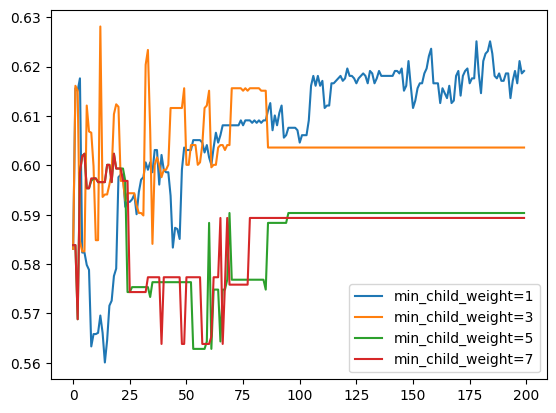

In [334]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

#plt.ylim(0.8, 0.84)
plt.legend()

- **min_child_weight=1**: Best performance - allows maximum flexibility
- **min_child_weight=3, 5, 7**: Increasing values show diminishing returns and lower AUC

**Decision:** Use **min_child_weight=1**. Unlike Random Forest (which needed min_samples_leaf=10), XGBoost's built-in regularization through learning rate and shallow trees makes additional leaf constraints unnecessary.


In [335]:
xgb_params = {
    'eta': 0.6, 
    'max_depth': 2,
    'min_child_weight': 1,
    #'reg_alpha': 0.1,  # L1 regularization
    #'reg_lambda': 1.0,  # L2 regularization

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [336]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.6196196196196196

## Model Comparison & Final Selection

### Performance Summary

| Model | Best Validation AUC | Key Parameters |
|-------|-------------------|----------------|
| **Decision Tree** | ~0.58 | max_depth=3, min_samples_leaf=15 |
| **Random Forest** | ~0.60 | n_estimators=200, max_depth=5, min_samples_leaf=10, max_features=0.2 |
| **XGBoost** | ~0.60 | eta=0.6, max_depth=2, min_child_weight=1, num_boost_round=175 |

### Key Insights

1. **Ensemble methods significantly outperform** single decision trees (+0.02 AUC, ~3% relative improvement)

2. **Random Forest vs XGBoost:**
   - Similar validation performance (~0.60 AUC)
   - Random Forest needs deeper trees (depth=5) and more feature randomness (20% features)
   - XGBoost achieves same performance with very shallow trees (depth=2) due to gradient boosting

3. **Feature characteristics:**
   - The dataset appears to have **many correlated features** (max_features=0.2 works best for RF)
   - Patterns are relatively **simple** (shallow trees work well)
   - Limited complexity in the target relationship (AUC plateaus at ~0.60)

### Final Model Selection: **Random Forest**

**Reasons:**
1. ✅ **Simplicity:** Fewer hyperparameters to tune, easier to explain
2. ✅ **Robustness:** Less sensitive to overfitting, no need for learning rate tuning
3. ✅ **Interpretability:** Feature importances are straightforward
4. ✅ **Production-ready:** Minimal risk of degradation on new data

**Final configuration:**
```python
RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=10,
    max_features=0.2,
    random_state=1
)
```

**Expected performance:** ~0.60 AUC on validation set

### Save model

In [39]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,0.2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
import pickle

# Save model
with open('random_forest_model.bin', 'wb') as f:
    pickle.dump(rf, f)

# Save the DictVectorizer
with open('dict_vectorizer.bin', 'wb') as f_out:
    pickle.dump(dv, f_out)

In [43]:
import pickle
input_file = 'random_forest_model.bin'
with open(input_file, 'rb') as f:
    model = pickle.load(f)

In [ ]:
model

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,0.2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
bacteria = {
  "growth_rate": 0.1338005,
  "peaks": 23,
  "circularity": 0.96578,
  "eccentricity": 0.18561,
  "RGB_mean_1": 246.7854,
  "RGBt_mean_2": 225.925,
  "RGBt_mean_3": 217.3063,
  "RGBt_std_1": 22.9483,
  "RGBt_std_2": 31.6416,
  "RGBt_std_3": 36.2281,
  "Lab_mean_1": 89.0539,
  "Lab_mean_2": 8.08953,
  "Lab_mean_3": 10.7003,
  "Lab_std_1": 11.1602,
  "Lab_std_2": 6.90168,
  "Lab_std_3": 8.14749,
  "Labt_mean_1": 91.3267,
  "Labt_mean_2": 6.5164,
  "Labt_mean_3": 7.15765,
  "Labt_std_1": 10.7217,
  "Labt_std_2": 4.70734,
  "Labt_std_3": 7.27739,
}

In [50]:
X = dv.transform([bacteria])
y_pred = model.predict(X)
y_pred

array([0])